# TP4 - TP5 - Filtrage Collaboratif et t-SNE

Dans ce travail, on implémente un modèle de filtrage collaboratif par factorisation matricielle. On testera les modèles sur des bases de données de films, avant d'utiliser une méthode de visualisation (t-SNE) pour observer nos résultats.

## Imports

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.spatial import distance

## Chargement des données

Les fonctions pour charger les bases Movie Lens 100k et Movie Lens 1M.
On récupère un dictionnaire pour les scores et un dictionnaire pour les dates.
Le première index de ces dictionnaires est l'identifiant de l'utilisateur, et le second les films notés.

In [2]:
def loadMovieLens(path='./data100k'):
    # Get movie titles
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
    # Load data
    prefs={} # Un dictionnaire User > Item > Rating
    times={} # Un dictionnaire User > Item > Timestamps
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
        times.setdefault(user,{})
        times[user][movies[movieid]]=float(ts)
    return prefs, times

In [3]:
def loadMovieLens1M(path='./data1m'):
    # Get movie titles
    movies={}
    for line in open(path+'/movies.dat'):
        id,title=line.split('::')[0:2]
        movies[id]=title
    # Load data
    prefs={}
    times={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
        times.setdefault(user,{})
        times[user][movies[movieid]]=float(ts)
    return prefs, times

## Représentations des données

Les matrices des scores Utilisateurs/Films sont des matrices de grandes dimensions mais sparses.
On propose 3 représentations possibles:
- Le dictionnaire des scores par utilisateurs: User > Item > Value
- Le dictionnaire des scores par films: Item > User > Value 
- La liste des triplets [User, Item, Value]

De fait, on utilisera dans la suite principalement la représentation sous forme de triplets. Les dictionnaires sont utilisés pour les baselines.

In [4]:
# Recupère une représentation des données sous la forme triplets [user, item, value] a partir d'un dictionnaire [User > item > value]
def getTripletsUsersItems(data):
    triplets = []
    for u in data.keys():
        for i in data[u].keys():
            triplets.append([u,i,data[u][i]])
    return triplets

# Construit le dictionnaire des utilisateurs a partir des triplets [user, item, note]
def buildUsersDict(triplets):
    dicUsers = {}
    for c in triplets:
        if not c[0] in dicUsers.keys():
            dicUsers[c[0]] = {}
        dicUsers[c[0]][c[1]] = float(c[2])
    return dicUsers

# Construit le dictionnaire des objets a partir des triplets [user, item, note]
def buildItemsDict(triplets):
    dicItems = {}
    for c in triplets:
        if not c[1] in dicItems:
            dicItems[c[1]] = {}
        dicItems[c[1]][c[0]] = float(c[2])
    return dicItems

## Séparation des données en Train / Test

Pour pouvoir séparer les données en ensembles de Train et de Test, on utilisera la liste des triplets [User, Item, Scores].

In [5]:
# Split l'ensemble des triplets [user, item, note] en testProp% données de test et (1 - testProp) données de train
def splitTrainTest(triplets,testProp):
    perm = np.random.permutation(triplets)
    splitIndex = int(testProp * len(triplets))
    return perm[splitIndex:], perm[:splitIndex]

# Modèles de factorisation matricielle

On implémente ici les différents modèles.

Pratiquement, on dispose d'une matrice $X$ de taille $N \times M$ sparse tel que $X_{u,i}$ contienne le score donné par l'utilisateur $u$ à l'objet $i$.
Il s'agit de trouver une matrice $U$ de taille $N\times K$ représentant les utilisateurs et une matrice $V$ de taille $M\times K$ représentant les objets de façon a minimiser les $|(UV')_{u,i} - X_{u,i}|$. On imposera $K << min(N,M)$.


## Baselines

Les baselines prédisent simplement la note moyenne pour un utilisateur (ou pour un film) donné. Les modèles de factorisation matricielles tentent d'approximer les valeurs connues de la matrice des scores par un produit de deux matrices de dimensions inférieurs.

In [6]:
class baselineMeanUsers():
    def __init__(self):
        self.mean = {}
    def fit(self, dataUsers):
        self.mean = {}
        for u in dataUsers.keys():
            self.mean[u] = 0
            for i in dataUsers[u].keys():
                self.mean[u] = self.mean[u] + dataUsers[u][i]
            self.mean[u] = self.mean[u] / len(dataUsers[u])
    def predict(self, testTriplets):
        pred = np.zeros(len(testTriplets))
        for ind,c in enumerate(testTriplets):
            pred[ind] = self.mean[c[0]]
        return pred
    
class baselineMeanItems():
    def __init__(self):            
        self.mean = {}
    def fit(self, dataItems):
        self.mean = {}
        for i in dataItems.keys():
            self.mean[i] = 0
            for u in dataItems[i].keys():
                self.mean[i] = self.mean[i] + dataItems[i][u]
            self.mean[i] = self.mean[i] / len(dataItems[i])
    def predict(self, testTriplets):
        pred = np.zeros(len(testTriplets))
        for ind,c in enumerate(testTriplets):
            pred[ind] = self.mean[c[1]]
        return pred

## Factorisation matricielle sans biais

On calcule les deux matrices P et Q tel que pour les exemples connus, PQ ~= X, où X est la matrice des scores.
Pour prédire, il suffit alors de lire dans la matrice PQ les nouveaux exemples.

In [7]:
class matrixFactorisation():
    def __init__(self, k, lambd=0.2, eps=1e-5, maxIter=2000, alternate=0):
        self.k = k
        self.lambd = lambd
        self.eps = eps
        self.maxIter = maxIter
        self.alternate = alternate #Pour l'optimisation alternée: 0 si non.
    def fit(self, triplets):
        self.p = {}
        self.q = {}
        self.loss = []
        #Choix du paramètre a optimisé en cas d'optimisation alternée
        optimP = True
        optimQ = (self.alternate == 0)
        for i in xrange(self.maxIter):
            loss = 0
            for j in xrange(len(triplets)):
                #choix d'une entrée aléatoire
                r = np.random.randint(len(triplets)) 
                user = triplets[r][0]
                item = triplets[r][1]
                value = float(triplets[r][2])
                # initialisation des nouveaux vecteurs p et q
                if not user in self.p:
                    self.p[user] = np.random.rand(1,self.k)
                if not item in self.q:
                    self.q[item] = np.random.rand(self.k,1)
                # Descente de gradient
                tmp = value - self.p[user].dot(self.q[item])[0][0]
                if (optimP):
                    self.p[user] = (1 - 2 * self.lambd * self.eps) * self.p[user] + self.eps * 2 * tmp * self.q[item].transpose()
                if (optimQ):
                    self.q[item] = (1 - 2 * self.lambd * self.eps) * self.q[item] + self.eps * 2 * tmp * self.p[user].transpose()
                loss = loss + tmp*tmp #(Sans le terme de régularisation)
            self.loss.append(loss)
            # Optimisation alternée
            if (self.alternate != 0):
                if (i % self.alternate == 0):
                    optimP = optimQ
                    optimQ = 1 - optimQ
                    print i, loss / len(triplets)
            else:
                if (i % 1000 == 0):
                    print i, loss / len(triplets)
    def predict(self, triplets):
        pred = np.zeros(len(triplets))
        for ind,c in enumerate(triplets):
            pred[ind] = self.p[c[0]].dot(self.q[c[1]])[0][0]
        return pred

## Factorisation matricielle avec biais

Ce modèle tiens compte d'un biais propre à chaque utilisateur et un biais propre à chaque film.
On cherche donc le scalaire $\mu$ et les matrices $P$,$Q$,$B_u$,$B_i$ tel que pour les exemples $(u,i)$ connus, $PQ(u,i) + B_u(u) + B_i(i) + \mu ~= X(u,i)$, où $X$ est la matrice des scores.
Pour prédire le score d'un nouvel exemple (u',i'), il suffit de calculer $PQ(u,i) + B_u(u) + B_i(i) + \mu$

In [8]:
# Comme matrixFactorisation() avec plus de paramètres
class matrixFactorisationBiais():
    def __init__(self, k, lambd=0.2, eps=1e-5, maxIter=10000, alternate=0):
        self.k = k
        self.lambd = lambd
        self.eps = eps
        self.maxIter = maxIter
        self.alternate = alternate
    def fit(self, triplets):
        self.p = {}
        self.q = {}
        self.bu = {}
        self.bi = {}
        self.mu = np.random.random() * 2 - 1
        self.loss = []
        optimP = True
        optimQ = (self.alternate == 0)
        for i in xrange(self.maxIter):
            loss = 0
            for j in xrange(len(triplets)):
                r = np.random.randint(len(triplets))
                user = triplets[r][0]
                item = triplets[r][1]
                value = float(triplets[r][2])
                if not user in self.p:
                    self.p[user] = np.random.rand(1,self.k) * 2 - 1
                    self.bu[user] = np.random.rand() * 2 - 1
                if not item in self.q:
                    self.q[item] = np.random.rand(self.k,1) * 2 - 1
                    self.bi[item] = np.random.rand() * 2 - 1
                tmp = value - (self.mu + self.bi[item] + self.bu[user] + self.p[user].dot(self.q[item])[0][0])
                if (optimP):
                    self.p[user] = (1 - self.lambd * self.eps) * self.p[user] + self.eps * 2 * tmp * self.q[item].transpose()
                    self.bu[user] = (1 - self.lambd * self.eps) * self.bu[user] + self.eps * 2 * tmp
                if (optimQ):
                    self.q[item] = (1 - 2 * self.lambd * self.eps) * self.q[item] + self.eps * 2 * tmp * self.p[user].transpose()
                    self.bi[item] = (1 - 2 * self.lambd * self.eps) * self.bi[item] + self.eps * 2 * tmp
                self.mu = (1 - self.lambd * self.eps) * self.mu + self.eps * 2 * tmp
                loss = loss + tmp*tmp
            self.loss.append(loss)
            if (self.alternate != 0):
                if (i % self.alternate == 0):
                    optimP = optimQ
                    optimQ = 1 - optimQ
                    print i, loss / len(triplets)
            else:
                if (i % 100 == 0):
                    print i, loss / len(triplets)
    def predict(self, triplets):
        pred = np.zeros(len(triplets))
        for ind,c in enumerate(triplets):
            pred[ind] = self.mu + self.bu[c[0]] + self.bi[c[1]] + self.p[c[0]].dot(self.q[c[1]])[0][0]
        return pred

# Tests les données Movie Lens 100k

Les données Movie Lens 100k comprennent 100 000 scores données par 1000 utilisateurs sur 1700 films.

## Préparation des données

On extrait aléatoirement une portion (20%) des données pour constituer la base de test, et le reste sera utilisé en apprentissage.

Comme on ne souhaite ne pas évaluer les objets et les utilisateurs qui n'ont jamais été rencontré en apprentissage, on retire les triplets correspondants de l'ensemble de test.

Reste ensuite à reconstruire les deux dictionnaires a partir de ces liste de triplets.

In [9]:
# Chargement
data, timestamps = loadMovieLens()

# Récupérer la représentation en liste de triplets
triplets = getTripletsUsersItems(data)

# La séparer en ensemble d'apprentissage et de test
trainTriplets, testTriplets = splitTrainTest(triplets,.20)

# Reconstruire les dictionnaires pour l'ensemble d'apprentissage
trainUsers = buildUsersDict(trainTriplets)
trainItems = buildItemsDict(trainTriplets)

# Supprimer de l'ensemble de test les éléments inconnus en apprentissage
toDel = []
for i,c in enumerate(testTriplets):
    if not c[0] in trainUsers:
        toDel.append(i)
    elif not c[1] in trainItems:
        toDel.append(i)
testTriplets = np.delete(testTriplets, toDel, 0)

# Reconstruire les dictionnaires pour l'ensemble de test
testUsers  = buildUsersDict(testTriplets)
testItems  = buildItemsDict(testTriplets)

# Récupérer les vecteurs des temps
#nbins = 5
#times = getTimeBins(triplets, timestamps, nbins)
#trainTimes = getTimeBins(trainTriplets, timestamps, nbins)
#testTimes = getTimeBins(testTriplets, timestamps, nbins)

# taille des données
#print len(trainUsers), len(testUsers)
#print len(trainItems), len(testItems)

## Baselines

On évalue ici les scores des baselines.
Comme les notes sont entre 1 et 5, on peut remarquer qu'en prédisant 3 tout le temps, on a nécessairement une erreur inférieur ou égale à 2.

Les deux baselines nous donnent un score un test d'environ 1.

In [10]:
model = baselineMeanUsers()
model.fit(trainUsers)
pred = model.predict(testTriplets)
print "erreur en test pour la baseline meanUsers:", ((pred - np.array(testTriplets[:,2], float)) ** 2).mean()

model = baselineMeanItems()
model.fit(trainItems)
pred = model.predict(testTriplets)
print "erreur en test pour la baseline meanItems:", ((pred - np.array(testTriplets[:,2], float)) ** 2).mean()

erreur en test pour la baseline meanUsers: 1.08669507807
erreur en test pour la baseline meanItems: 1.04687414823


## Factorisation matricielle sans biais

Après selection des hyperparamètres par Grid Search, on obtient une erreur en test de 0.86 avec lambda=0.05 et k=5. Il est meilleur que les baselines de 0,14 point.
On observe un grand écart entre l'erreur de test et l'erreur en apprentissage qui est de 0.54.
Cela est caractéristique d'un surapprentissage. Pourtant, augmenter le paramètre de régularisation fait aussi chuter les performances en validation.

In [11]:
nIter = 10000

lambdas = [0.05, 0.1, 0.2, 0.3]
ks = [5,10,20,30]

bestErrNoBias = 10

for l in lambdas:
    for k in ks:
        model = matrixFactorisation(k, lambd=l, maxIter=nIter, alternate=0)
        model.fit(trainTriplets)
        pred = model.predict(testTriplets)
        err = ((pred - np.array(testTriplets[:,2], float)) ** 2).mean()
        print 'lambda =', l
        print 'k =', k
        print 'Erreur en validation :', err
        print 'Erreur de train:', model.loss[-1] / len(triplets) 
        print ""
        if err < bestErrNoBias:            
            bestErrNoBias = err
            bestModelNoBias = model
            f = open('modelNoBias_l' + str(l) + "_k" + str(k) + "_err" + str(err) +  '.pkl', 'w')
            pkl.dump(model, f)
            f.close()

f = open('bestModelNoBias.pkl', 'w')
pkl.dump(bestModelNoBias, f)
f.close()

lambda = 0.05
k = 5
Erreur en validation : 0.861330677952
erreur de train: 0.577390430464

lambda = 0.05
k = 10
Erreur en validation : 0.883655107884
erreur de train: 0.518317984491

lambda = 0.05
k = 20
Erreur en validation : 0.903779532218
erreur de train: 0.42889331175

lambda = 0.05
k = 30
Erreur en validation : 0.900842015395
erreur de train: 0.369079107582

lambda = 0.1
k = 5
Erreur en validation : 0.876272935709
erreur de train: 0.61667703864

lambda = 0.1
k = 10
Erreur en validation : 0.870238861249
erreur de train: 0.586157098446

lambda = 0.1
k = 20
Erreur en validation : 0.877711321808
erreur de train: 0.536304770256

lambda = 0.1
k = 30
Erreur en validation : 0.881345019064
erreur de train: 0.502942852038

lambda = 0.2
k = 5
Erreur en validation : 0.926488756339
erreur de train: 0.693575761071

lambda = 0.2
k = 10
Erreur en validation : 0.918457577206
erreur de train: 0.686016038882

lambda = 0.2
k = 20
Erreur en validation : 0.931973736378
erreur de train: 0.674548595059



## Factorisation matricielle avec biais

Après selection des hyperparamètres par Grid Search, on obtient une erreur en test de 0.89 avec lambda=0.2 et k=5. On est moins bon que sur le modèle sans biais.
Comparativement au modèle précédent, la Grid Search choisi un paramètre k identique mais un paramètre lambda de régularisation plus fort.
Ce modèle étant plus expressif, cette observation est cohérente avec l'hypothèse de surapprentissage. L'erreur de validation est ici de 0.64.

In [12]:
nIter = 10000

lambdas = [0.05, 0.1, 0.2, 0.3]
ks = [5,10,20,30]

bestErr = 10

for l in lambdas:
    for k in ks:
        model = matrixFactorisationBiais(k, lambd=l, maxIter=nIter, alternate=0)
        model.fit(trainTriplets)
        pred = model.predict(testTriplets)
        err = ((pred - np.array(testTriplets[:,2], float)) ** 2).mean()
        print 'lambda =', l
        print 'k =', k
        print 'Erreur en validation :', err
        print 'Erreur de train:', model.loss[-1] / len(triplets)
        print ""
        if err < bestErr:
            bestErr = err
            bestModel = model
            f = open('model_l' + str(l) + "_k" + str(k) + "_err" + str(err) +  '.pkl', 'w')
            pkl.dump(model, f)
            f.close()

f = open('bestModel.pkl', 'w')
pkl.dump(bestModel, f)
f.close()

lambda = 0.05
k = 5
Erreur en validation : 0.931343013476
erreur de train: 0.592100915331

lambda = 0.05
k = 10
Erreur en validation : 0.938304711078
erreur de train: 0.512145853885

lambda = 0.05
k = 20
Erreur en validation : 1.02774540113
erreur de train: 0.410735483968

lambda = 0.05
k = 30
Erreur en validation : 1.11352830424
erreur de train: 0.352330515472

lambda = 0.1
k = 5
Erreur en validation : 0.902359635092
erreur de train: 0.590870230274

lambda = 0.1
k = 10
Erreur en validation : 0.902239323926
erreur de train: 0.53726428298

lambda = 0.1
k = 20
Erreur en validation : 0.945478097718
erreur de train: 0.471240824416

lambda = 0.1
k = 30
Erreur en validation : 0.968351291422
erreur de train: 0.41202536547

lambda = 0.2
k = 5
Erreur en validation : 0.889335433599
erreur de train: 0.63895982603

lambda = 0.2
k = 10
Erreur en validation : 0.902143474659
erreur de train: 0.628787975386

lambda = 0.2
k = 20
Erreur en validation : 0.92044743435
erreur de train: 0.579077704347

lamb

# Experiences sur les données Movie Lens 1M

Le dataset Movie Lens 1M contient 1 million d'entrées, données par 6000 utiilisateurs sur 4000 films.

Une remarque que l'on peut déjà faire est que la matrice des scores est "moins sparse" que celle issue de la base 100k.

En effet, pour la base 100k on a 100000 notes pour une matrice 1000x1700, soit un remplissage de 17% de la matrice.

Pour la base 1M, on a 1 000 000 de notes pour une matrice 6000x4000, soit 24% de remplissage.

## Préparation des données

In [13]:
# Chargement
data1M, timestamps = loadMovieLens1M()

# Récupérer la représentation en liste de triplets
triplets1M = getTripletsUsersItems(data1M)

# La séparer en ensemble d'apprentissage et de test
trainTriplets1M, testTriplets1M = splitTrainTest(triplets1M,.20)

# Reconstruire les dictionnaires pour l'ensemble d'apprentissage
trainUsers1M = buildUsersDict(trainTriplets1M)
trainItems1M = buildItemsDict(trainTriplets1M)

# Supprimer de l'ensemble de test les éléments inconnus en apprentissage
toDel = []
for i,c in enumerate(testTriplets1M):
    if not c[0] in trainUsers1M:
        toDel.append(i)
    elif not c[1] in trainItems1M:
        toDel.append(i)
testTriplets1M = np.delete(testTriplets1M, toDel, 0)

# Reconstruire les dictionnaires pour l'ensemble de test
testUsers1M  = buildUsersDict(testTriplets1M)
testItems1M  = buildItemsDict(testTriplets1M)

# Récupérer les vecteurs des temps
#nbins = 5
#times = getTimeBins(triplets, timestamps, nbins)
#trainTimes = getTimeBins(trainTriplets, timestamps, nbins)
#testTimes = getTimeBins(testTriplets, timestamps, nbins)

# taille des données
#print len(trainUsers), len(testUsers)
#print len(trainItems), len(testItems)

## Baselines

Si le score de la baseline par utilisateur est similaire comparé au dataset précédent, le score de baseline par objet en revanche est meilleur que sur la base 100k.
On est ici à 0.96 d'erreur moyenne.

In [14]:
data, timestamps = loadMovieLens()model = baselineMeanUsers()
model.fit(trainUsers1M)
pred = model.predict(testTriplets1M)
print "erreur en test pour la baseline meanUsers:", ((pred - np.array(testTriplets1M[:,2], float)) ** 2).mean()

model = baselineMeanItems()
model.fit(trainItems1M)
pred = model.predict(testTriplets1M)
print "erreur en test pour la baseline meanItems:", ((pred - np.array(testTriplets1M[:,2], float)) ** 2).mean()

erreur en test pour la baseline meanUsers: 1.07394279377
erreur en test pour la baseline meanItems: 0.95809108838


## Factorisation Matricielle sans biais

Le comportement sur la base 1M est similaire à celui obtenue sur la base 100k.
Les paramètres optimaux choisis sont les même (lambda=0.05 et k=5), et on obtient une erreur sur la base d'apprentissage de 0.65 et sur la base de test de 0.83. 
La factorisation matricielle est meilleure que celle de la base 100k, probablement parceque la matrice d'apprentissage est moins sparse.

In [15]:
nIter = 2000

lambdas = [0.05, 0.1, 0.2, 0.3]
ks = [10,20,30,5]

bestErrNoBias1M = 10

for l in lambdas:
    for k in ks:
        model = matrixFactorisation(k, lambd=l, maxIter=nIter, alternate=0)
        model.fit(trainTriplets1M)
        pred = model.predict(testTriplets1M)
        err = ((pred - np.array(testTriplets1M[:,2], float)) ** 2).mean()
        print 'lambda =', l
        print 'k =', k #5
        print 'Erreur en validation :', err
        print 'Erreur de train:', model.loss[-1] / len(triplets) 
        print ""
        if err < bestErrNoBias1M:
            bestErrNoBias1M = err
            bestModelNoBias1M = model
            f = open('modelNoBias1M_l' + str(l) + "_k" + str(k) + "_err" + str(err) +  '.pkl', 'w')
            pkl.dump(model, f)
            f.close()

f = open('bestModelNoBias1M.pkl', 'w')
pkl.dump(bestModelNoBias1M, f)
f.close()

lambda = 0.05
k = 10
Erreur en validation : 0.835326426206
erreur de train: 0.638133536398

lambda = 0.05
k = 20
Erreur en validation : 0.838266576569
erreur de train: 0.62152566821

lambda = 0.05
k = 30
Erreur en validation : 0.841051794009
erreur de train: 0.60410538043

lambda = 0.05
k = 5
Erreur en validation : 0.834059004239
erreur de train: 0.646643360906

lambda = 0.1
k = 10
Erreur en validation : 0.849642993475
erreur de train: 0.650766263501

lambda = 0.1
k = 20
Erreur en validation : 0.842541883105
erreur de train: 0.642499149069

lambda = 0.1
k = 30
Erreur en validation : 0.851000162775
erreur de train: 0.634249255446

lambda = 0.1
k = 5
Erreur en validation : 0.841367361412
erreur de train: 0.655355977915

lambda = 0.2
k = 10
Erreur en validation : 0.873477084079
erreur de train: 0.680394504608

lambda = 0.2
k = 20
Erreur en validation : 0.872095661444
erreur de train: 0.676763287902

lambda = 0.2
k = 30
Erreur en validation : 0.876094198963
erreur de train: 0.673830620901


## Factorisation Matricielle avec biais

Le meilleur modèle est à nouveau avec lambda=0.05 et k = 5, avec une erreur en validation de 0.85 et en apprentissage de 0.65. Le modèle obtient des résultats très similaires avec biais ou sans.

In [16]:
nIter = 2000

lambdas = [0.05, 0.1, 0.2, 0.3]
ks = [10,20,30,5]

bestErr1M = 10

for l in lambdas:
    for k in ks:
        model = matrixFactorisationBiais(k, lambd=l, maxIter=nIter, alternate=0)
        model.fit(trainTriplets1M)
        pred = model.predict(testTriplets1M)
        err = ((pred - np.array(testTriplets1M[:,2], float)) ** 2).mean()
        print 'lambda =', l
        print 'k =', k #5
        print 'Erreur en validation :', err
        print 'Erreur de train:', model.loss[-1] / len(triplets) 
        print ""
        if err < bestErr1M:
            bestErr1M = err
            bestModel1M = model
            f = open('model1M_l' + str(l) + "_k" + str(k) + "_err" + str(err) +  '.pkl', 'w')
            pkl.dump(model, f)
            f.close()

f = open('bestModel1M.pkl', 'w')
pkl.dump(bestModel1M, f)
f.close()

lambda = 0.05
k = 5
Erreur en validation : 0.847592293261
erreur de train: 0.650574739869

lambda = 0.05
k = 10
Erreur en validation : 0.866495635685
erreur de train: 0.639165484073

lambda = 0.05
k = 20
Erreur en validation : 0.898985789452
erreur de train: 0.61992982385

lambda = 0.05
k = 30
Erreur en validation : 0.936669540293
erreur de train: 0.601516630445

lambda = 0.1
k = 5
Erreur en validation : 0.858444543128
erreur de train: 0.659306411224

lambda = 0.1
k = 10
Erreur en validation : 0.870188306979
erreur de train: 0.648609350631

lambda = 0.1
k = 20
Erreur en validation : 0.889979555237
erreur de train: 0.631698624015

lambda = 0.1
k = 30
Erreur en validation : 0.911317542666
erreur de train: 0.616777353255

lambda = 0.2
k = 5
Erreur en validation : 0.884579346653
erreur de train: 0.683383320637

lambda = 0.2
k = 10
Erreur en validation : 0.88953717509
erreur de train: 0.677881164481

lambda = 0.2
k = 20
Erreur en validation : 0.898411240875
erreur de train: 0.666923903081



# tSNE

Dans cette seconde partie, on utilise l'algorithme t-SNE pour tenter de visualiser la représentation des films apprise.

L'algorithme modélise par une similarité gaussienne la proximité deux à deux des examples dans l'espace de départ. Il modélise de la même façon la proximité des éléments de l'espace d'arrivée entre eux, et cherche à minimiser un critère de Kullback-Leibler sur ces deux distributions en effectuant une descente de gradient sur les coordonnées des points de l'espace d'arrivée.

Au préalable, l'algorithme doit calculer les paramètres sigmas pour la similarité. Il procède pour cela par dichotomie, optimisant un critère de perplexité.

In [17]:
class tSNE():
    def __init__(self,perp, nIter, lr, moment, dim=2):
        self.perp = perp # entre 5 et 50
        self.nIter = nIter
        self.lr = lr
        self.moment = moment
        self.dim = dim 
    def fit(self,data):
        nEx = np.shape(data)[0]
        # Matrice des distances de ||xi - xj||² #
        normx = np.sum(data**2,1)
        normx = np.reshape(normx, (1, nEx))
        distancex = normx + normx.T - 2 * data.dot(data.T)
        # Calcul des sigma ---------------------------------------------------------------#
        lperp = np.log2(self.perp)
        # initialisation bornes pour la recherche dichotomique #
        sup = np.ones((nEx,1)) * np.max(distancex)
        inf = np.zeros((nEx,1))
        self.sigma = (sup + inf) / 2.
        # recherche dichotomique #
        stop = False
        while not stop:
            # Calculer la matrice des p(i|j)
            self.pcond = np.exp(-distancex / (2. * (self.sigma**2)))
            self.pcond = self.pcond / np.sum(self.pcond - np.eye(nEx),1).reshape(nEx,1)
            # Calculer l'entropie de p(i|j)
            entropy = - np.sum(self.pcond * np.log2(self.pcond), 0)
            # Mise a jour des bornes
              # Si il faut augmenter sigma
            up = entropy < lperp 
            inf[up,0] = self.sigma[up,0]
              # Si il faut baisser sigma
            down = entropy > lperp 
            sup[down,0] = self.sigma[down,0]
            # Mise a jour de sigma et condition d'arrêt
            old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(old - self.sigma)) < 1e-5:
                stop = True
                #print np.exp(entropy)
                #print self.sigma.T  
        #--------------------------------------------------------------------------#
        #initialiser y
        self.embeddings = np.zeros((self.nIter+2, nEx, self.dim))
        self.embeddings[1] = np.random.randn(nEx, self.dim) * 1e-4
        #--------------------------------------------------------------------------#
        # p(ij)
        self.pij = (self.pcond + self.pcond.T) / (2.*nEx)
        np.fill_diagonal(self.pij, 0)
        # Descente de Gradient
        loss = []
        for t in xrange(1,self.nIter+1):
            # Matrice des distances 
            normy = np.sum((self.embeddings[t]**2),1)
            normy = np.reshape(normy, (1, nEx))
            distancey = normy + normy.T - 2 * self.embeddings[t].dot(self.embeddings[t].T)
            # q(ij)
            # self.qij = (distancey.sum() + nEx*(nEx-1)) / (1 + distancey)
            # np.fill_diagonal(self.qij, 0)
            self.qij = 1 / (1 + distancey)
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij / self.qij.sum()
            # Descente de gradient
            yt = self.embeddings[t]
            tmpgrad = 4 * ((self.pij - self.qij) / (1 + distancey)).reshape(nEx, nEx,1)
            for i in range(nEx):
                dy = (tmpgrad[i] * (yt[i]-yt)).sum(0)
                self.embeddings[t+1][i] = yt[i] - self.lr * dy + self.moment * (yt[i] - self.embeddings[t-1,i])
            l = stats.entropy(self.pij, self.qij, 2).mean()
            loss.append(l)
            if (t % 100 == 0):
                print t,l

## Tests sur des chiffres manuscrits

Dans un premier temps, on test le bon fonctionnement de notre implémentation sur une base de chiffres manuscrits.

100 1.9165594597
200 1.64374025751
300 1.51933867067
400 1.44417712942
500 1.39224903863
600 1.35360278525
700 1.32351276297
800 1.29885251148
900 1.27841306563
1000 1.26103945706
1100 1.24604075188
1200 1.23293197663
1300 1.22134805207
1400 1.21092149697
1500 1.2016418708
1600 1.19330348771
1700 1.18570665933
1800 1.17874822876
1900 1.17234376401
2000 1.16639548779
2100 1.16082967825
2200 1.15562688846
2300 1.15075110846
2400 1.14611066203
2500 1.1415435612
2600 1.13667963088
2700 1.1319771109
2800 1.12764953127
2900 1.12362523532
3000 1.11983955778
3100 1.11628201246
3200 1.11295895658
3300 1.10982283454
3400 1.10699159898
3500 1.10432118833
3600 1.10174741134
3700 1.09928013407
3800 1.09691654268
3900 1.09464364455
4000 1.09242236633
4100 1.0902706576
4200 1.08814498651
4300 1.0860950621
4400 1.08420552755
4500 1.08240252416
4600 1.08068632164
4700 1.07903453561
4800 1.07744396913
4900 1.07591051746
5000 1.07442943781


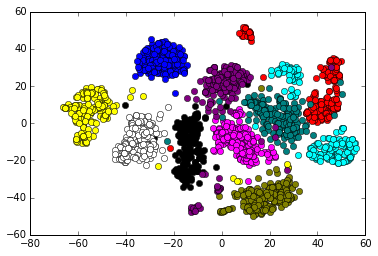

In [18]:
from sklearn import datasets
data = datasets.load_digits()

model = tSNE(10,5000,1000,0)
model.fit(data.data)

t = np.shape(model.embeddings)[0] -1
plt.figure()
plt.plot(model.embeddings[t,:,0][data.target == 0], model.embeddings[t,:,1][data.target == 0], 'o', color="blue")
plt.plot(model.embeddings[t,:,0][data.target == 1], model.embeddings[t,:,1][data.target == 1], 'o', color="red")
plt.plot(model.embeddings[t,:,0][data.target == 2], model.embeddings[t,:,1][data.target == 2], 'o', color="cyan")
plt.plot(model.embeddings[t,:,0][data.target == 3], model.embeddings[t,:,1][data.target == 3], 'o', color="magenta")
plt.plot(model.embeddings[t,:,0][data.target == 4], model.embeddings[t,:,1][data.target == 4], 'o', color="yellow")
plt.plot(model.embeddings[t,:,0][data.target == 5], model.embeddings[t,:,1][data.target == 5], 'o', color="black")
plt.plot(model.embeddings[t,:,0][data.target == 6], model.embeddings[t,:,1][data.target == 6], 'o', color="white")
plt.plot(model.embeddings[t,:,0][data.target == 7], model.embeddings[t,:,1][data.target == 7], 'o', color=(0.5, 0.5, 0))
plt.plot(model.embeddings[t,:,0][data.target == 8], model.embeddings[t,:,1][data.target == 8], 'o', color=(0,0.5,0.5))
plt.plot(model.embeddings[t,:,0][data.target == 9], model.embeddings[t,:,1][data.target == 9], 'o', color=(0.5,0,0.5))
plt.show()

# Movie Lens 100k

On essaye à présent de visualiser la représentation des films donné par notre meilleur modèle sur Movie Lens 100k.

In [19]:
fichier = open("./bestModelNoBias.pkl")
reco = pkl.load(fichier)
fichier.close()

In [20]:
k = 5
movies = np.zeros((len(reco.q),k))
titles = []
for i,q in enumerate(reco.q.keys()):
    movies[i] = np.reshape(reco.q[q],k,1)
    titles.append(q)

In [21]:
model = tSNE(30,10000,1e3,0)
model.fit(movies)
t = len(model.embeddings) - 1

100 2.42965810392
200 2.18758441686
300 2.07134134108
400 1.99600556435
500 1.94464564615
600 1.9039674603
700 1.87305392942
800 1.84807822689
900 1.82635458118
1000 1.80826851433
1100 1.79128403904
1200 1.77750494726
1300 1.7662561914
1400 1.75537095872
1500 1.74515739049
1600 1.73633252246
1700 1.72850714021
1800 1.72122504229
1900 1.71440249433
2000 1.70850412809
2100 1.70290031938
2200 1.69749211853
2300 1.69260108026
2400 1.68816653025
2500 1.68389270024
2600 1.68003507548
2700 1.67629856025
2800 1.6729146917
2900 1.66954351736
3000 1.66653411903
3100 1.66370407932
3200 1.66102067734
3300 1.65828291154
3400 1.6558640484
3500 1.65338878241
3600 1.65119828937
3700 1.64901840258
3800 1.64695405157
3900 1.64489745544
4000 1.64303933011
4100 1.64122212976
4200 1.63950523841
4300 1.63785786806
4400 1.6362725915
4500 1.63473299564
4600 1.63330542137
4700 1.63190565857
4800 1.63052742958
4900 1.62920150766
5000 1.62791392828
5100 1.62666691602
5200 1.62544815693
5300 1.62426987608
5400 1.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in greater


## Visualisation par notes

On affiche ici les films par note moyenne. Globalement, on constate que les films mal très notés (sombres) se situent dans une même zone au centre vers le bas gauche, et les films très bien notés se situent plutôt vers la droite ou le haut.

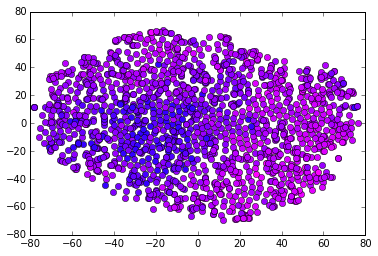

In [22]:
meanItem = baselineMeanItems()
meanItem.fit(trainItems)

for i, txt in enumerate(titles):
    if txt in meanItem.mean:
        plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color=(meanItem.mean[txt] / 5, meanItem.mean[txt] / 5, 1))

## Visualisation par réalisateur

En faisant l'hypothèse que certains grands réalisateurs ont une patte spécifique et touche un publique particulier, on se dit qu'il pourrait être intéressant de voir si oui ou non l'algorithme à placer leurs films proches les uns des autres.

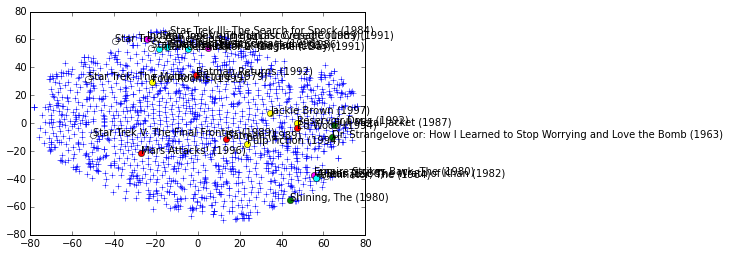

In [50]:
plt.figure()

plt.plot(model.embeddings[t,:,0],model.embeddings[t,:,1], '+', color="blue")

kubrick = ['Full Metal Jacket', 'Shining', 'Eyes Wide Shut', 'Barry Lyndon', 'A Clockwork Orange', 'Dr. Strangelove', 'Lolita', 'Spartacus']
burton = ['Pee-Wee', 'Beetlejuice', 'Batman (1989)', 'Batman Returns', 'Edward Scissorhands', 'Ed Wood', 'Mars Attacks', 'Sleepy Hollow']
tarantino= ['Reservoir Dogs', 'Pulp Fiction', 'Four Rooms', 'Jackie Brown']
lucas = ['A New Hope', 'Empire Strikes Back', 'Return of the Jedi', 'Indiana Jones']
cameron = [ 'Piranha', 'Terminator', 'Aliens', 'The Abyss', 'True Lies', 'Titanic']

for i, txt in enumerate(titles):
    if (np.random.rand() > 0):
        for film in burton:
            if film in txt.decode('latin-1'):
                plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
                plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color="red")
        for film in kubrick:
            if film in txt.decode('latin-1'):
                plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
                plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color="green")
        for film in tarantino:
            if film in txt.decode('latin-1'):
                plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
                plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color="yellow")
        for film in lucas:
            if film in txt.decode('latin-1'):
                plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
                plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color="magenta")
        for film in cameron:
            if film in txt.decode('latin-1'):
                plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
                plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color="cyan")
        if "Star Trek" in txt.decode('latin-1'):
                plt.annotate(txt.decode('latin-1'), model.embeddings[t,i])
                plt.plot(model.embeddings[t,i,0],model.embeddings[t,i,1], 'o', color="white")
plt.show()



Bien qu'on n'observe pas de structure évidenten il est intéressant de constater que parmi les films choisi se distinguent 2 clusters dans lesquelles on retrouve les films de Georges Lucas, James Cameron et des Star Trek. Ce qui semble une disposition raisonnable. Ce sont des films qui attirent vraisemblablement le même type de spectateurs.

On zoom ici sur ces deux zones (celle en haut et celle en bas a droite):
![alt text](./figure_1.png "")
![alt text](./figure_.png "")

## Visualisation par categorie

On affiche ici les catégories auquel appartiennent chaque film. Il ne se dégage pas de pattern clair dans leur distributions.

In [23]:
def loadMovieCategories(path='./data100k'):
    movies={}
    for line in open(path+'/u.item'):
        labels = ["action", "aventure", "animation", "children", "comedy", "crime", "documentary", "drama", "fantasy", "noir", "horror", "musical", "mystery", "romance", "scifi", "thriller", "war", "western"]
        (id,title,_,_,_,_,action, aventure, animation, children, comedy, crime, documentary, drama, fantasy, noir, horror, musical, mystery, romance, scifi, thriller, war, western)=line.split('|')
        movies[title]=np.array([action, aventure, animation, children, comedy, crime, documentary, drama, fantasy, noir, horror, musical, mystery, romance, scifi, thriller, war, western], int)
    return movies, labels

action


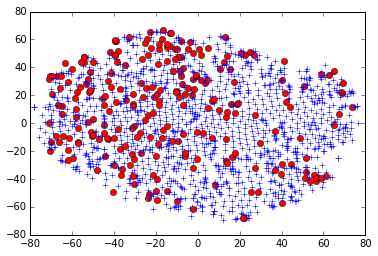

aventure


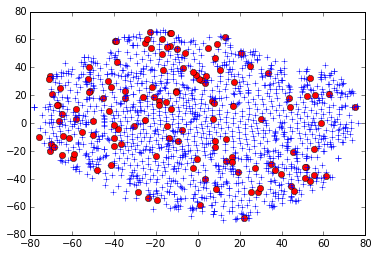

animation


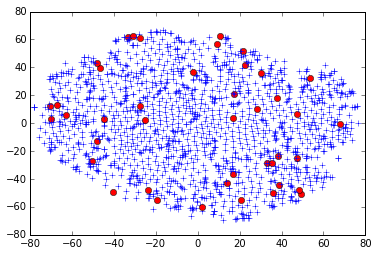

children


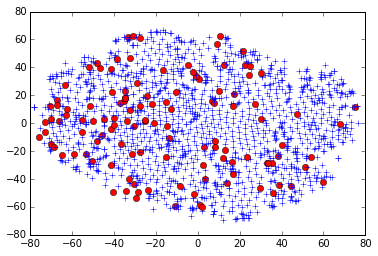

comedy


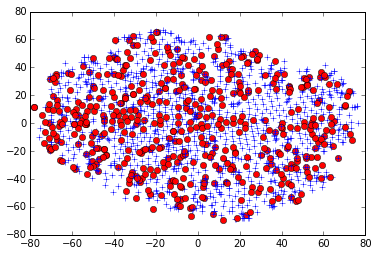

crime


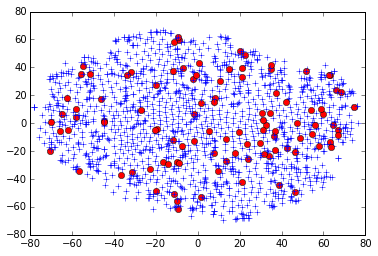

documentary


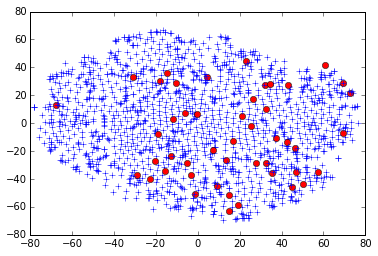

drama


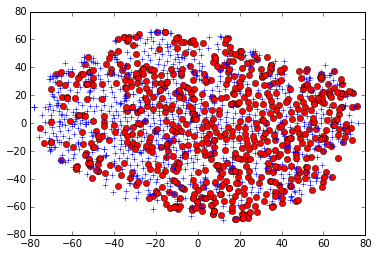

fantasy


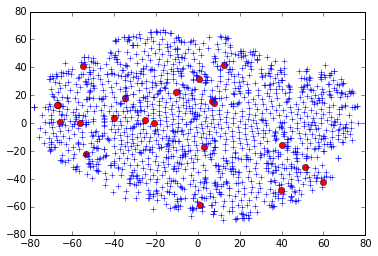

noir


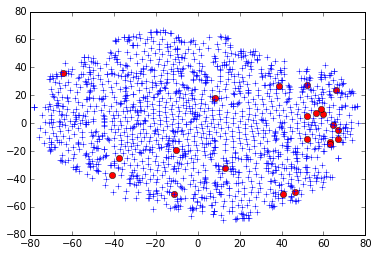

horror


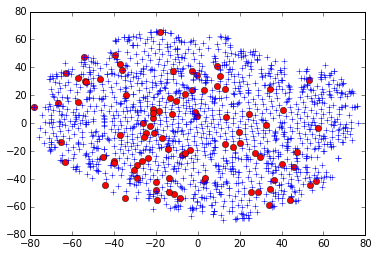

musical


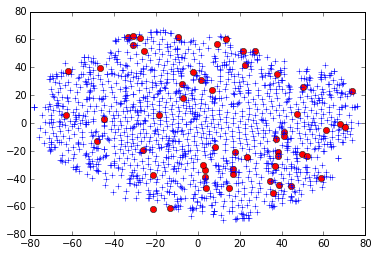

mystery


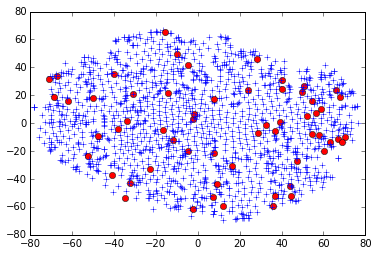

romance


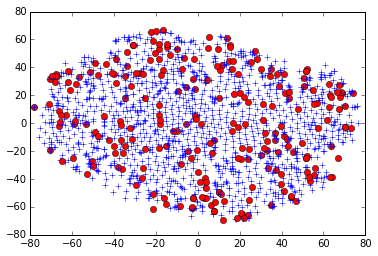

scifi


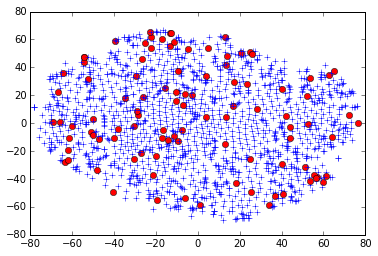

thriller


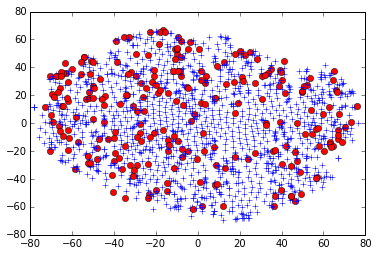

war


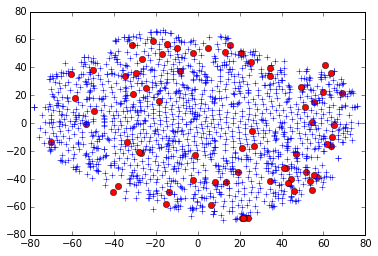

western


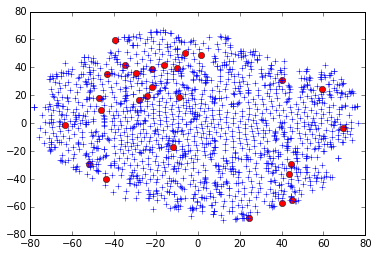

In [24]:
categories, labels = loadMovieCategories()

for i in xrange(len(labels)):
    print labels[i]
    plt.figure()
    for j,txt in enumerate(titles):
        if (categories[txt][i] == 0):
            plt.plot(model.embeddings[t,j,0],model.embeddings[t,j,1], '+', color="blue")
        else:
            plt.plot(model.embeddings[t,j,0],model.embeddings[t,j,1], 'o', color="red")
    plt.show()

# Conclusion

Dans ce rapport, on a utilisé la factorisation matricielle avec ou sans biais sur deux dataset de tailles différentes.
Dans les deux cas, le modèle sans biais est meilleur que le modèle avec biais par utilisateur et pas film.


Dans tous les cas, la Grid Search choisi un nombre de dimension de représentation faible (k=5) et montre un grand écart entre les erreurs sur l'ensemble de validation et l'ensemble d'apprentissage. Il est étonnant que cette différence peine à être réduite par l'optimisation du paramètre de régularisation. En effet, dans 3 cas sur 4, le lambda choisi est le plus faible de la Grid Search: lambda = 0.05 et augmenter la régularisation.

Concernant la visualisation des films avec t-SNE, on peut observer empiriquement quelques rapprochement qui semblent pertinents. Mais il est difficile d'évaluer la pertinence de la représentation obtenue.